In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
!pip install -Uq gdown
!pip install split-folders
!pip install natsort
!pip install torch transformers datasets evaluate pillow==9.2.0

!pip uninstall timm --y
!pip -q install --pre timm
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.9 MB/s eta 0:00:00


In [ ]:
import splitfolders
from glob import glob
from tqdm.autonotebook import tqdm, trange
from numba import njit, jit
from natsort import natsorted

import matplotlib.pyplot as plt

from PIL import Image, ImageOps

from random import sample

import cv2


from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

from scipy import stats


import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform


import warnings
warnings.filterwarnings('ignore')

<ipython-input-3-2ccb2a62a6b5>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_files = glob("/content/drive/MyDrive/Data/train/**/*")

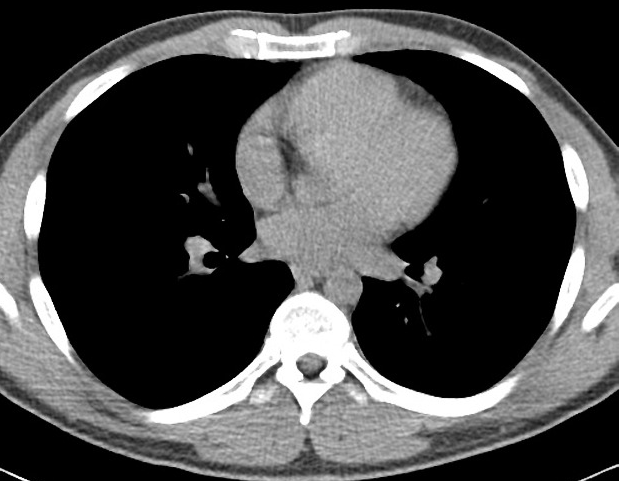

In [ ]:
example = Image.open(train_files[1]).convert("RGB")
display(example)

In [ ]:
img_size = 384
transforms = {
    "train": T.Compose([
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
    ]),
    "test": T.Compose([
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
    ])
}

In [ ]:
dataset = ImageDataset("/content/drive/MyDrive/Data/train", transform=transforms["train"])
id2label = natsorted(os.listdir('/content/drive/MyDrive/Data/train'))

In [ ]:
id2label

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [ ]:
len(train_files)

613

In [ ]:
y = glob('/content/drive/MyDrive/Data/train/**/*')
y = natsorted(y)
y = [os.path.basename(os.path.dirname(i)) for i in y]

len(id2label), len(y) #len class, len sample

(4, 613)

In [ ]:
from torchmetrics.classification import MulticlassF1Score

In [ ]:
device = torch.device("cuda")
model_name = 'resnet50'
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 4
eval_batch_size = 4
num_accumulate = 4
num_classes = len(id2label)

# Cross Validation Configuration
k_splits = 5
metric = MulticlassF1Score(num_classes = 4)

In [ ]:
all_eval_scores = []
eval_scores = []
!rm -rf croos_model
!mkdir croos_model

skf = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=42)
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, y)):
# for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

    print(f"\nFold {fold+1} of 10")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)

    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)

    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

    # Reset Model Info
    info = {
        "metric_train": ['com'],
        "metric_val": ['com'],
        "train_loss": ['com'],
        "val_loss": ['com'],
        "best_metric_val": -999,
    }

    count = 0
    eval_scores.append([])
    for epoch in range(num_epochs):

        train_loss_epoch = []
        val_loss_epoch = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        num_updates = epoch * len(train_dataloader)

        ### === Train Loop === ###

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))

            loss.backward()

            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            # ============================= #

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()

        optimizer.step()
        scheduler.step(epoch + 1)

        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))

                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###

        # Log Data

        train_preds = torch.FloatTensor(train_preds)
        train_targets = torch.FloatTensor(train_targets)
        val_preds = torch.FloatTensor(val_preds)
        val_targets = torch.FloatTensor(val_targets)

        metric_train = metric(train_preds, train_targets)
        metric_val = metric(val_preds, val_targets)

        info["metric_train"][0] = metric_train
        info["metric_val"][0] = metric_val

        info["train_loss"][0] = np.average(train_loss_epoch)
        info["val_loss"][0] = np.average(val_loss_epoch)

        eval_scores[-1].append(metric_val)
        if metric_val > info["best_metric_val"]:
            print("\nNew Best Score!")
            info["best_metric_val"] = metric_val
            torch.save(model, f"croos_model/checkpoint_fold{fold}.pt")
            count = 0

        else:
            count += 1

        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}\n")


    all_eval_scores.append(info["best_metric_val"])


Fold 1 of 10


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3904)], 'metric_val': [tensor(0.3579)], 'train_loss': [1.2152964429157536], 'val_loss': [1.0037621889383561], 'best_metric_val': tensor(0.3579)}
Fold: 0 | Epoch: 0 | Metric: 0.357887864112854 | Training Loss: 1.2152964429157536 | Validation Loss: 1.0037621889383561



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6050)], 'metric_val': [tensor(0.8269)], 'train_loss': [0.8568519804535842], 'val_loss': [0.581158356981412], 'best_metric_val': tensor(0.8269)}
Fold: 0 | Epoch: 1 | Metric: 0.8268761038780212 | Training Loss: 0.8568519804535842 | Validation Loss: 0.581158356981412



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8478)], 'metric_val': [tensor(0.8802)], 'train_loss': [0.459307782230823], 'val_loss': [0.3808038984876006], 'best_metric_val': tensor(0.8802)}
Fold: 0 | Epoch: 2 | Metric: 0.8801731467247009 | Training Loss: 0.459307782230823 | Validation Loss: 0.3808038984876006



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9308)], 'metric_val': [tensor(0.9004)], 'train_loss': [0.2741152128068412], 'val_loss': [0.3250182551902629], 'best_metric_val': tensor(0.9004)}
Fold: 0 | Epoch: 3 | Metric: 0.9004433155059814 | Training Loss: 0.2741152128068412 | Validation Loss: 0.3250182551902629



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9430)], 'metric_val': [tensor(0.8910)], 'train_loss': [0.1998347288255042], 'val_loss': [0.41593825689426833], 'best_metric_val': tensor(0.9004)}
Fold: 0 | Epoch: 4 | Metric: 0.8910120129585266 | Training Loss: 0.1998347288255042 | Validation Loss: 0.41593825689426833


Fold 2 of 10


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3966)], 'metric_val': [tensor(0.4557)], 'train_loss': [1.1771646263153572], 'val_loss': [0.8739226580627503], 'best_metric_val': tensor(0.4557)}
Fold: 1 | Epoch: 0 | Metric: 0.45566511154174805 | Training Loss: 1.1771646263153572 | Validation Loss: 0.8739226580627503



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6448)], 'metric_val': [tensor(0.6942)], 'train_loss': [0.7689843027572322], 'val_loss': [0.7197239978103748], 'best_metric_val': tensor(0.6942)}
Fold: 1 | Epoch: 1 | Metric: 0.6941903233528137 | Training Loss: 0.7689843027572322 | Validation Loss: 0.7197239978103748



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8240)], 'metric_val': [tensor(0.9524)], 'train_loss': [0.5075664309466758], 'val_loss': [0.25480010835153444], 'best_metric_val': tensor(0.9524)}
Fold: 1 | Epoch: 2 | Metric: 0.9524009227752686 | Training Loss: 0.5075664309466758 | Validation Loss: 0.25480010835153444



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9250)], 'metric_val': [tensor(0.9683)], 'train_loss': [0.2500851957990629], 'val_loss': [0.1559033533858676], 'best_metric_val': tensor(0.9683)}
Fold: 1 | Epoch: 3 | Metric: 0.9682971239089966 | Training Loss: 0.2500851957990629 | Validation Loss: 0.1559033533858676



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9607)], 'metric_val': [tensor(0.9927)], 'train_loss': [0.18400703490204443], 'val_loss': [0.10887597141517026], 'best_metric_val': tensor(0.9927)}
Fold: 1 | Epoch: 4 | Metric: 0.9927371144294739 | Training Loss: 0.18400703490204443 | Validation Loss: 0.10887597141517026


Fold 3 of 10


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.4350)], 'metric_val': [tensor(0.6367)], 'train_loss': [1.1638342781764706], 'val_loss': [0.9270130604986222], 'best_metric_val': tensor(0.6367)}
Fold: 2 | Epoch: 0 | Metric: 0.6366738080978394 | Training Loss: 1.1638342781764706 | Validation Loss: 0.9270130604986222



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6658)], 'metric_val': [tensor(0.8077)], 'train_loss': [0.7616640603154655], 'val_loss': [0.5599254879259294], 'best_metric_val': tensor(0.8077)}
Fold: 2 | Epoch: 1 | Metric: 0.8076825737953186 | Training Loss: 0.7616640603154655 | Validation Loss: 0.5599254879259294



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8755)], 'metric_val': [tensor(0.8967)], 'train_loss': [0.411059723758116], 'val_loss': [0.31907120431142466], 'best_metric_val': tensor(0.8967)}
Fold: 2 | Epoch: 2 | Metric: 0.8966845273971558 | Training Loss: 0.411059723758116 | Validation Loss: 0.31907120431142466



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9372)], 'metric_val': [tensor(0.9527)], 'train_loss': [0.22799028372922078], 'val_loss': [0.19001797383891478], 'best_metric_val': tensor(0.9527)}
Fold: 2 | Epoch: 3 | Metric: 0.9526792168617249 | Training Loss: 0.22799028372922078 | Validation Loss: 0.19001797383891478



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9629)], 'metric_val': [tensor(0.9511)], 'train_loss': [0.1438215810472403], 'val_loss': [0.14715275750495493], 'best_metric_val': tensor(0.9527)}
Fold: 2 | Epoch: 4 | Metric: 0.9510964155197144 | Training Loss: 0.1438215810472403 | Validation Loss: 0.14715275750495493


Fold 4 of 10


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3880)], 'metric_val': [tensor(0.5331)], 'train_loss': [1.1795818119998869], 'val_loss': [0.939163809341769], 'best_metric_val': tensor(0.5331)}
Fold: 3 | Epoch: 0 | Metric: 0.5331318378448486 | Training Loss: 1.1795818119998869 | Validation Loss: 0.939163809341769



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6340)], 'metric_val': [tensor(0.6050)], 'train_loss': [0.8163793500119109], 'val_loss': [0.9292215095652688], 'best_metric_val': tensor(0.6050)}
Fold: 3 | Epoch: 1 | Metric: 0.6050264835357666 | Training Loss: 0.8163793500119109 | Validation Loss: 0.9292215095652688



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8048)], 'metric_val': [tensor(0.8105)], 'train_loss': [0.5162763679172935], 'val_loss': [0.5030988863398952], 'best_metric_val': tensor(0.8105)}
Fold: 3 | Epoch: 2 | Metric: 0.8104933500289917 | Training Loss: 0.5162763679172935 | Validation Loss: 0.5030988863398952



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9446)], 'metric_val': [tensor(0.9391)], 'train_loss': [0.24774233636453868], 'val_loss': [0.23746885467065318], 'best_metric_val': tensor(0.9391)}
Fold: 3 | Epoch: 3 | Metric: 0.9391340017318726 | Training Loss: 0.24774233636453868 | Validation Loss: 0.23746885467065318



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9543)], 'metric_val': [tensor(0.9555)], 'train_loss': [0.19836730416106985], 'val_loss': [0.21392850362275156], 'best_metric_val': tensor(0.9555)}
Fold: 3 | Epoch: 4 | Metric: 0.955539882183075 | Training Loss: 0.19836730416106985 | Validation Loss: 0.21392850362275156


Fold 5 of 10


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3941)], 'metric_val': [tensor(0.4317)], 'train_loss': [1.2012065430966818], 'val_loss': [0.9436445745729631], 'best_metric_val': tensor(0.4317)}
Fold: 4 | Epoch: 0 | Metric: 0.43166667222976685 | Training Loss: 1.2012065430966818 | Validation Loss: 0.9436445745729631



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6015)], 'metric_val': [tensor(0.6071)], 'train_loss': [0.8148651949273862], 'val_loss': [0.7812506933846781], 'best_metric_val': tensor(0.6071)}
Fold: 4 | Epoch: 1 | Metric: 0.6071004271507263 | Training Loss: 0.8148651949273862 | Validation Loss: 0.7812506933846781



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8111)], 'metric_val': [tensor(0.9144)], 'train_loss': [0.5148650599204427], 'val_loss': [0.31097023927741835], 'best_metric_val': tensor(0.9144)}
Fold: 4 | Epoch: 2 | Metric: 0.9143536686897278 | Training Loss: 0.5148650599204427 | Validation Loss: 0.31097023927741835



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9185)], 'metric_val': [tensor(0.9602)], 'train_loss': [0.2743352906763311], 'val_loss': [0.1931681308835264], 'best_metric_val': tensor(0.9602)}
Fold: 4 | Epoch: 3 | Metric: 0.9602216482162476 | Training Loss: 0.2743352906763311 | Validation Loss: 0.1931681308835264



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9723)], 'metric_val': [tensor(0.9376)], 'train_loss': [0.16995190810866473], 'val_loss': [0.19736486598248443], 'best_metric_val': tensor(0.9602)}
Fold: 4 | Epoch: 4 | Metric: 0.9376225471496582 | Training Loss: 0.16995190810866473 | Validation Loss: 0.19736486598248443



In [ ]:
best_accuracy = max(all_eval_scores)
print(f"The best accuracy achieved across all folds is: {best_accuracy}")

The best accuracy achieved across all folds is: 0.9927371144294739


In [ ]:
import os

checkpoint_dir = "croos_model/"
checkpoints = os.listdir(checkpoint_dir)
fold_checkpoints = [checkpoint for checkpoint in checkpoints if checkpoint.startswith("checkpoint_fold")]
num_checkpoints = len(fold_checkpoints)

print(f"You have {num_checkpoints} fold checkpoints.")
print("Fold checkpoints:", fold_checkpoints)



You have 5 fold checkpoints.
Fold checkpoints: ['checkpoint_fold3.pt', 'checkpoint_fold0.pt', 'checkpoint_fold1.pt', 'checkpoint_fold4.pt', 'checkpoint_fold2.pt']


In [ ]:
# Load the model checkpoint
model_path = "croos_model/checkpoint_fold4.pt"  # Replace {fold} with the specific fold number you want to test
model = torch.load(model_path)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:

test_transforms = transforms["test"]  # Assuming you have defined transforms for the test dataset

test_dataset = ImageDataset("/content/drive/MyDrive/Data/test", transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)


In [ ]:
test_preds = []
test_targets = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs, targets = batch
        outputs = model(inputs.to(device))
        test_preds += outputs.argmax(-1).detach().cpu().tolist()
        test_targets += targets.tolist()

# Convert predictions and targets to torch tensors
test_preds = torch.FloatTensor(test_preds)
test_targets = torch.FloatTensor(test_targets)

# Calculate test accuracy or any other metrics you need
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy}")


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.8539682539682539


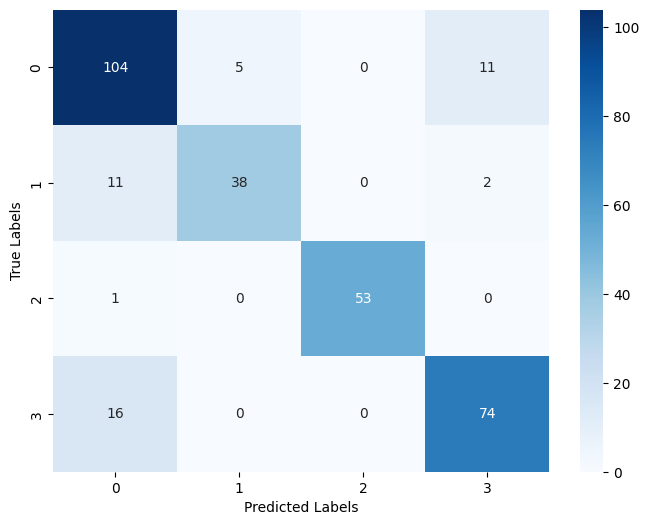

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
conf_matrix = confusion_matrix(test_targets, test_preds)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming test_preds and test_targets are lists or arrays
# Convert them to numpy arrays if they are not already in that form
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Generate classification report
class_report = classification_report(test_targets, test_preds, target_names=id2label)

# Print the classification report
print(class_report)


                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.79      0.87      0.83       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.88      0.75      0.81        51
                                          normal       1.00      0.98      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.85      0.82      0.84        90

                                        accuracy                           0.85       315
                                       macro avg       0.88      0.85      0.87       315
                                    weighted avg       0.86      0.85      0.85       315



In [ ]:
from sklearn.metrics import classification_report

# Assuming test_preds and test_targets are lists or arrays
# Convert them to numpy arrays if they are not already in that form
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Generate classification report
class_report = classification_report(test_targets, test_preds, target_names=id2label, output_dict=True)

# Access accuracy for each class from the classification report
class_accuracy = {class_name: report['precision'] for class_name, report in class_report.items() if class_name in id2label}

# Display accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Class: {class_name}, Accuracy: {accuracy}")


Class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib, Accuracy: 0.7878787878787878
Class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa, Accuracy: 0.8837209302325582
Class: normal, Accuracy: 1.0
Class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa, Accuracy: 0.8505747126436781


                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.79      0.87      0.83       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.88      0.75      0.81        51
                                          normal       1.00      0.98      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.85      0.82      0.84        90

                                        accuracy                           0.85       315
                                       macro avg       0.88      0.85      0.87       315
                                    weighted avg       0.86      0.85      0.85       315



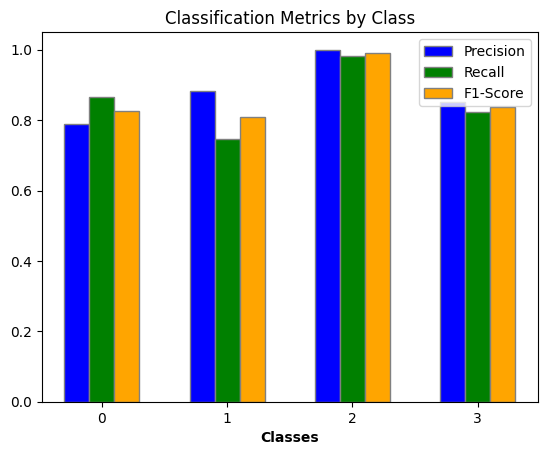

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Assuming test_preds and test_targets are lists or arrays
# Convert them to numpy arrays if they are not already in that form
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Generate classification report
class_report = classification_report(test_targets, test_preds, target_names=id2label)

# Print the classification report
print(class_report)

# Extract precision, recall, and F1-score from the classification report using scikit-learn functions
precision, recall, f1_score, _ = precision_recall_fscore_support(test_targets, test_preds)

# Assuming id2label is a list of class labels
class_labels = id2label

# Set the bar width
bar_width = 0.2

# Set the positions of bars on X-axis
r1 = np.arange(len(class_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
labell=[0,1,2,3]
# Plot the bars
plt.bar(r1, precision, color='blue', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='green', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='orange', width=bar_width, edgecolor='grey', label='F1-Score')

# Add labels to the chart
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labell))], labell)

# Add legend & title
plt.legend()
plt.title('Classification Metrics by Class')

# Show the plot
plt.show()
